# L3 – Convolutional neural network

### Materials
1. [ImageNet](http://www.image-net.org)
2. [Overview](https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layer) on wiki.
3. Stanford's [course](http://cs231n.stanford.edu) on convolutional networks + some [materials](http://cs231n.github.io/convolutional-networks/) on github.
4. [Pooling](https://arxiv.org/pdf/1412.6806.pdf)
5. [Dropout](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
6. [Batch normalization](https://arxiv.org/pdf/1502.03167.pdf)
7. [Data augmentation](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)

### Models
1. [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
2. [AlexNet](http://papers.nips.cc/book/advances-in-neural-information-processing-systems-25-2012)
3. [VGGNet](https://arxiv.org/pdf/1409.1556.pdf)
4. [GoogLeNet](https://arxiv.org/pdf/1409.4842)
5. [ResNet](https://arxiv.org/pdf/1512.03385.pdf)

### Tutorials
1. [Guide](https://www.tensorflow.org/tutorials/layers) to conv nets training
2. More advanced [tutorial](https://www.tensorflow.org/tutorials/deep_cnn)
3. How to [using GPUs](https://www.tensorflow.org/tutorials/using_gpu)

### 1. Convolution
Convolutional Layer is the core building block of a conv nets.

#### Overview and intuition
The conv layer’s parameters consist of a set of learnable filters. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. For example, a typical filter on a first layer of some conv net might have size $3 \times 3 \times 3$ (i.e. 3 pixels width and height, and 3 because images have depth 3, RGB channels). During the forward pass, we slide (more precisely, convolve) each filter across the width and height of the input volume and compute dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Intuitively, the network will learn filters that activate when they see some type of visual feature such as an edge of some orientation or a blotch of some color on the first layer, or eventually entire honeycomb or wheel-like patterns on higher layers of the network. Now, we will have an entire set of filters in each conv layer, and each of them will produce a separate 2-dimensional activation map. We will stack these activation maps along the depth dimension and produce the output volume.

#### Local connectivity
When dealing with high-dimensional inputs such as images, as we saw above it is impractical to connect neurons to all neurons in the previous volume. Instead, we will connect each neuron to only a local region of the input volume. The spatial extent of this connectivity is a hyperparameter called the receptive field of the neuron (equivalently this is the filter size). The extent of the connectivity along the depth axis is always equal to the depth of the input volume. It is important to emphasize again this asymmetry in how we treat the spatial dimensions (width and height) and the depth dimension: The connections are local in space (along width and height), but always full along the entire depth of the input volume.

#### Spatial arrangement.
We have explained the connectivity of each neuron in the conv layer to the input volume, but we have not yet discussed how many neurons there are in the output volume or how they are arranged. Three hyperparameters control the size of the output volume: the depth, stride and zero-padding.

1. First, the **depth** of the output volume. It corresponds to the number of filters we would like to use, each learning to look for something different in the input. For example, if the first convolutional Layer takes as input the raw image, then different neurons along the depth dimension may activate in presence of various oriented edges, or blobs of color. We will refer to a set of neurons that are all looking at the same region of the input as a depth column.

2. Second, we must specify the **stride** with which we slide the filter. When the stride is $1$ then we move the filters one pixel at a time. When the stride is $2$ (or uncommonly $3$ or more, though this is rare in practice) then the filters jump $2$ pixels at a time as we slide them around. This will produce smaller output volumes spatially.

3. As we will soon see, sometimes it will be convenient to pad the input volume with zeros around the border. The size of this **zero-padding** is a hyperparameter. The nice feature of zero padding is that it will allow us to control the spatial size of the output volumes (exactly preserve the spatial size of the input volume so the input and output width and height are the same).

#### Implementation as matrix multiplication
Note that the convolution operation essentially performs dot products between the filters and local regions of the input. A common implementation pattern of the conv layer is to take advantage of this fact and formulate the forward pass of a convolutional layer as one big matrix multiply. This approach has the downside that it can use a lot of memory, since some values in the input volume are replicated multiple times. However, the benefit is that there are many very efficient implementations of Matrix Multiplication that we can take advantage of (for example, in the commonly used [BLAS API](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms)).

#### Backpropagation
The backward pass for a convolution operation (for both the data and the weights) is also a convolution (but with spatially-flipped filters). This is easy to derive in the 1-dimensional case with a toy example.

#### Convolution $1 \times 1$
Several papers use $1 \times 1$ convolutions. Some people are at first confused to see $1 \times 1$ convolutions especially when they come from signal processing background. Normally signals are 2-dimensional so $1 \times 1$ convolutions do not make sense (it’s just pointwise scaling). However, we must remember that we operate over 3-dimensional volumes, and that the filters always extend through the full depth of the input volume. For example, if the input is $n \times n \times 3$ then doing $1 \times 1$ convolutions would effectively be doing 3-dimensional dot products (since the input depth is 3 channels).

### 2. Classic architecture
The crown of straightforward architectures for convolutional networks is probably [VGG](https://arxiv.org/pdf/1409.1556.pdf). In fact it is a chain of a fixed set of layers. The most common form of a conv net architecture stacks a few conv + ReLu layers, follows them with pool layers, and repeats this pattern until the image has been merged spatially to a small size. At some point, it is common to transition to fully connected layers. The last fully connected layer holds the output, such as the class scores. In more detail below.

#### Convolution layer
The conv layers should be using small filters (e.g. $3 \times 3$ or at most $5 \times 5$), using a stride equals $1$, and crucially, padding the input volume with zeros in such way that the conv layer does not alter the spatial dimensions of the input. That is, when filter size is $3$ then using padding equals $1$ to preserves the input size.

#### Pooling layer
Another important concept is pooling, which is a form of non-linear down-sampling. There are several non-linear functions to implement pooling among which max pooling is the most common. It partitions the input image into a set of non-overlapping rectangles and, for each such sub-region, outputs the maximum. The intuition is that the exact location of a feature is less important than its rough location relative to other features. The pooling layer serves to progressively reduce the spatial size of the representation, to reduce the number of parameters and amount of computation in the network, and hence to also control overfitting. It is common to periodically insert a pooling layer between successive convolutional layers in a CNN architecture. The pooling operation provides another form of translation invariance.

The pooling layer operates independently on every depth slice of the input and resizes it spatially. The most common form is a pooling layer with filters of size $2 \times 2$ applied with a stride of $2$ downsamples at every depth slice in the input by $2$ along both width and height. 

In addition to max pooling, the pooling units can use other functions, such as average pooling. Average pooling was often used historically but has recently fallen out of favor compared to max pooling, which works better in practice. Due to the aggressive reduction in the size of the representation, the trend is towards using smaller filters or discarding the pooling layer altogether.

#### Activation function (nonlinearity)
ReLU is the abbreviation of Rectified Linear Units. This layer applies the non-saturating activation function 
$\sigma(x) = \max(0,x).$ It increases the nonlinear properties of the decision function and of the overall network without affecting the receptive fields of the convolution layer. Other functions are also used to increase nonlinearity, for example the saturating hyperbolic tangent and the sigmoid function $f(x)=(1+e^{-x})^{-1}$. ReLU is often preferred to other functions, because it trains the neural network several times faster without a significant penalty to generalisation accuracy. Also there are several variations such as LeakyReLU or ELU.

#### Fully connected layer (dense layer)
Finally, after several convolutional and max pooling layers, the high-level reasoning in the neural network is done via fully connected layers. Neurons in a fully connected layer have connections to all activations in the previous layer, as seen in regular neural networks. Their activations can hence be computed with a matrix multiplication followed by a bias offset.

It is worth noting that the only difference between FC (fully connected layer) and conv layer is that the neurons in the conv layer are connected only to a local region in the input, and that many of the neurons in a conv volume share parameters. However, the neurons in both layers still compute dot products, so their functional form is identical. Therefore, it turns out that it is possible to convert from FC to conv layers.

For example, an FC layer with output size $K$ that is looking at some input volume of size $S \times S \times F$ can be equivalently expressed as a conv layer with size $S$, padding $0$, stride $1$ and number of filters equals $K$.

#### Loss function
The loss layer specifies how training penalizes the deviation between the predicted and true labels and is normally the final layer. Various loss functions appropriate for different tasks may be used there. [Softmax](https://en.wikipedia.org/wiki/Softmax_function) is used for predicting a single class of $K$ mutually exclusive classes. [Sigmoid cross-entropy](https://www.tensorflow.org/api_docs/python/tf/losses/sigmoid_cross_entropy) is used for predicting $K$ independent probability values. [Euclidean loss](https://en.wikipedia.org/wiki/Root-mean-square_deviation) is used for regressing to real-valued labels.


#### Exercises
1. Download dataset from [kaggle](https://www.kaggle.com/c/ch-2017).
2. Suggest some your net architecture (start with something really simple).
3. What quality do you achieve?
4. Can you transform VGG model for your problem?
5. What is your score?
6. Imagine that your conv net makes forward path. How can you estimate your memory consumption?
7. Now you make backpropagation step. Why does it require much more memory?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torchvision
import torchvision.transforms as transforms

import PIL
from PIL import Image

### Loading first part of dataset and plotting some elements

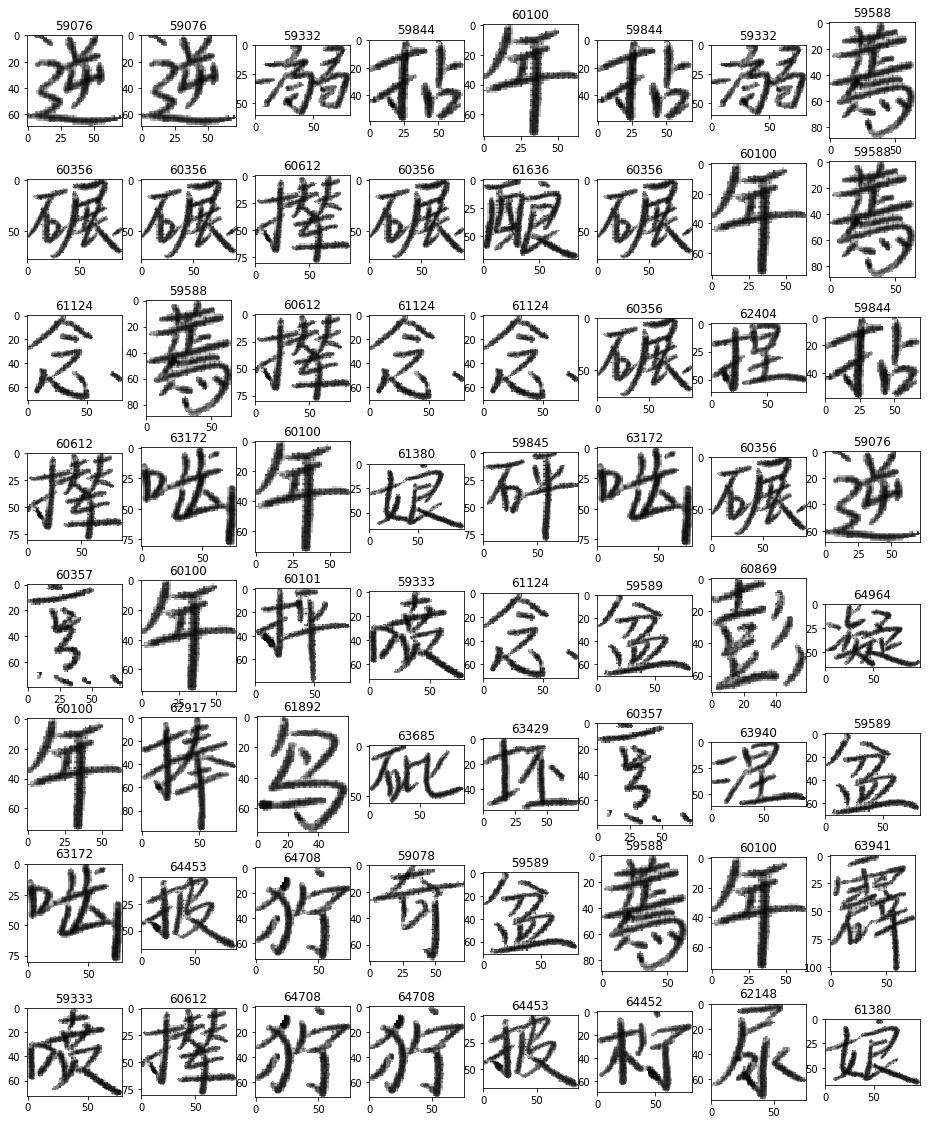

In [3]:
dataIm = np.load('Ieroglifs/train-1.npy')
width, height = 8, 8

plt.figure(figsize=(16, 20))
for n, (image, tag) in enumerate(dataIm, 1):
    if n > width * height:
        break
    plt.subplot(height, width, n)
    plt.title(tag)
    plt.imshow(image, cmap='gray')

### Loading and transforming lasts

In [4]:
dataIm = np.load('Ieroglifs/train-1.npy')

for (image, tag) in dataIm:
    im = Image.fromarray(image)
    im = im.resize((100, 100), PIL.Image.HAMMING)
    im.show()
    break

In [15]:
size = 50
trainFeatures = []
trainLabels = []
testFeatures = []
testLabels = []

dataIm = np.load('Ieroglifs/train-1.npy')
for (image, tag) in dataIm:
    newImage = Image.fromarray(image)
    newImage = newImage.resize((size, size), PIL.Image.HAMMING)
    trainFeatures.append(torch.from_numpy(np.asarray(newImage)))
    trainLabels.append(tag)
print("first")

dataIm = np.load('Ieroglifs/train-2.npy')
for (image, tag) in dataIm:
    newImage = Image.fromarray(image)
    newImage = newImage.resize((size, size), PIL.Image.HAMMING)
    trainFeatures.append(torch.from_numpy(np.asarray(newImage)))
    trainLabels.append(tag)
print("second")

dataIm = np.load('Ieroglifs/train-3.npy')
for (image, tag) in dataIm:
    newImage = Image.fromarray(image)
    newImage = newImage.resize((size, size), PIL.Image.HAMMING)
    trainFeatures.append(torch.from_numpy(np.asarray(newImage)))
    trainLabels.append(tag)
print("third")

dataIm = np.load('Ieroglifs/train-4.npy')
for (image, tag) in dataIm:
    newImage = Image.fromarray(image)
    newImage = newImage.resize((size, size), PIL.Image.HAMMING)
    trainFeatures.append(torch.from_numpy(np.asarray(newImage)))
    trainLabels.append(tag)
print("fourth")

first
second
third
fourth


### And test

In [6]:
# dataIm = np.load('Ieroglifs/test.npy')
# for image in dataIm:
#     newImage = Image.fromarray(image)
#     newImage = newImage.resize((100, 100), PIL.Image.HAMMING)
#     testFeatures.append(torch.from_numpy(np.asarray(newImage)))
# print("test")

In [16]:
trainFeatures = torch.stack(trainFeatures)
#testFeatures = torch.stack(testFeatures)

### Making model

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(3, 6, 5)
        #self.fc1 = nn.Linear(6 * 5 * 5, 30)
        #self.fc3 = nn.Linear(30, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(-1, 6 * 5 * 5)
        #x = F.relu(self.fc1(x))
        #x = self.fc2(x)
        return x

In [15]:
def train(trainFeatures, trainLabels):
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(20):  # loop over the dataset multiple times
        running_loss = 0.0
        #for i in range(len(trainFeatures)):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(trainFeatures)
        loss = criterion(outputs, trainLabels)
        loss.backward()
        optimizer.step()
        # print statistics
        print(epoch, loss.item())

    print('Finished Training')

In [16]:
net = Net()

train(trainFeatures, trainLabels)
outputs = net(torch.from_numpy(np.asarray(trainFeatures)).float())

_, predicted = torch.max(outputs, 1)
predicted = predicted.numpy()
correct, total = 0, 0
for i in range(len(predicted)):
    if trainLabels[i] == predicted[i]:
        correct += 1
    total += 1

print("We have", correct/total * 100, "% accuracy.")


TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not list

### 3. Regularization
Regularization is a process of introducing additional information in order to solve an ill-posed problem or to prevent overfitting. It is possible to use various types of regularization for conv nets. You are already familiar with the classic $L1$ and $L2$ regularization, consider a more specific techniques.

#### Early stopping
One more method to prevent overfitting of a network is to simply stop the training before overfitting has had a chance to occur. It comes with the disadvantage that the learning process is halted. Also it is common solution to slowly decreace learning rate.

#### Dropout
Because a fully connected layer occupies most of the parameters, it is prone to overfitting. One method to reduce overfitting is [dropout](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf). At each training stage, individual nodes are either "dropped out" of the net with probability $1-p$ or kept with probability $p$, so that a reduced network is left; incoming and outgoing edges to a dropped-out node are also removed. Only the reduced network is trained on the data in that stage. The removed nodes are then reinserted into the network with their original weights. In the training stages, the probability that a hidden node will be dropped is usually $0.5$, for input nodes, this should be much lower, intuitively because information is directly lost when input nodes are ignored.

At testing time after training has finished, we would ideally like to find a sample average of all possible $2^{n}$ dropped-out networks, unfortunately this is unfeasible for large values of $n$. However, we can find an approximation by using the full network with each node's output weighted by a factor of $p$, so the expected value of the output of any node is the same as in the training stages. This is the biggest contribution of the dropout method: although it effectively generates $2^{n}$ neural nets, and as such allows for model combination, at test time only a single network needs to be tested.

By avoiding training all nodes on all training data, dropout decreases overfitting. The method also significantly improves training speed. This makes model combination practical, even for deep neural nets. The technique seems to reduce node interactions, leading them to learn more robust features that better generalize to new data.

#### Stochastic pooling
A major drawback to dropout is that it does not have the same benefits for convolutional layers, where the neurons are not fully connected.

In [stochastic pooling](https://arxiv.org/abs/1301.3557), the conventional deterministic pooling operations are replaced with a stochastic procedure, where the activation within each pooling region is picked randomly according to a multinomial distribution, given by the activities within the pooling region. The approach is hyperparameter free and can be combined with other regularization approaches, such as dropout and data augmentation.

An alternate view of stochastic pooling is that it is equivalent to standard max pooling but with many copies of an input image, each having small local deformations. This is similar to explicit elastic deformations of the input images, which delivers excellent MNIST performance. Using stochastic pooling in a multilayer model gives an exponential number of deformations since the selections in higher layers are independent of those below.

#### Batch normalization
[Batch normalization](https://arxiv.org/pdf/1502.03167.pdf) is a method for improving the performance and stability of neural networks, and also makes more sophisticated deep learning architectures work in practice.
The idea is to normalise the inputs of each layer in such a way that they have a mean output activation of zero and standard deviation of one. This is analogous to how the inputs to networks are standardised.

How does this help? We know that normalising the inputs to a network helps it learn. But a network is just a series of layers, where the output of one layer becomes the input to the next. That means we can think of any layer in a neural network as the first layer of a smaller subsequent network. Thought of as a series of neural networks feeding into each other, we normalising the output of one layer before applying the activation function, and then feed it into the following layer. It’s called "batch" normalization because during training, we normalise the activations of the previous layer for each batch, i.e. apply a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

1. Networks train faster – whilst each training iteration will be slower because of the extra normalisation calculations during the forward pass and the additional hyperparameters to train during back propagation. However, it should converge much more quickly, so training should be faster overall.
2. Allows higher learning rates — gradient descent usually requires small learning rates for the network to converge. As networks get deeper, gradients get smaller during back propagation, and so require even more iterations. Using batch normalisation allows much higher learning rates, increasing the speed at which networks train.
3. Makes weights easier to initialise — weight initialisation can be difficult, especially when creating deeper networks. Batch normalisation helps reduce the sensitivity to the initial starting weights.
4. Makes more activation functions viable — some activation functions don’t work well in certain situations. Sigmoids lose their gradient quickly, which means they can’t be used in deep networks, and ReLUs often die out during training (stop learning completely), so we must be careful about the range of values fed into them.
5. Provides some regularisation — batch normalisation adds a little noise to your network, and in some cases, (e.g. Inception modules) it has been shown to work as well as dropout. You can consider batch normalisation as a bit of extra regularization, allowing you to reduce some of the dropout you might add to a network.

#### Exercises
1. Try to use regularization that you like more (batch normalization is strongly recommended).
2. Does it help to improve the quality of classification? What methods do you use?

### 4. Data augmentation
Data augmentation is another way we can reduce overfitting on models, where we increase the amount of training data using information only in our training data. It is common knowledge that the more data an ML algorithm has access to, the more effective it can be. Even when the data is of lower quality, algorithms can actually perform better, as long as useful data can be extracted by the model from the original data set. For example, text-to-speech and text-based models have improved significantly due to the release of a trillion-word corpus by Google. This result is despite the fact that the data is collected from unfiltered web pages and contains many errors. With such large and unstructured data sets, however, the task becomes one of finding structure within a sea of unstructured data.

However, alternative approaches exist. Rather than starting with an extremely large corpus of unstructured and unlabeled data, can we instead take a small, curated corpus of structured data and augment in a way that increases the performance of models trained on it? This approach has proven effective in multiple problems.

A very generic and accepted current practice for augmenting image data is to perform geometric and color augmentations, such as reflecting the image, cropping and translating the image, and changing the color palette of the image. Specifically, digit data was augmented with elastic deformations, in addition to the typical affine transformation.

#### Exercises
1. Try to use some simple augmentation techniques, e.g. rotation, scaling and etc.
2. Does it help to improve the quality of classification?
3. You can read [this paper](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf) for more information.

### 5. Modern architecture
In practice, it is better to use whatever works best on [ImageNet](http://www.image-net.org). If you’re feeling a bit of a fatigue in thinking about the architectural decisions, you will be pleased to know that in 90% or more of applications you should not have to worry about these. Instead of rolling your own architecture for a problem, you should look at whatever architecture currently works best on ImageNet, download a pretrained model and finetune it on your data. You should rarely ever have to train a ConvNet from scratch or design one from scratch.

It should be noted that the conventional paradigm of a linear list of layers has recently been challenged, in Google’s inception architectures and also in current (state of the art) residual networks from Microsoft Research Asia. Both of these (see details below) feature more intricate and different connectivity structures.

**GoogLeNet** The ILSVRC 2014 winner was a Convolutional Network from Google. Its main contribution was the development of an [inception module](https://arxiv.org/pdf/1409.4842) that dramatically reduced the number of parameters in the network (4M, compared to AlexNet with 60M). Additionally, this paper uses average pooling instead of fully connected layers at the top of the net, eliminating a large amount of parameters that do not seem to matter much. There are also several versions to the GoogLeNet, most recently [inception-v4](https://arxiv.org/pdf/1602.07261).

**ResNet** [Residual networks](https://arxiv.org/pdf/1512.03385) developed was the winner of ILSVRC 2015. It features special skip connections and a heavy use of batch normalization. The architecture is also missing fully connected layers at the end of the network. ResNets are currently by far state of the art conv net models and are the default choice for using in practice. In particular, also see more recent developments that tweak the original architecture, e.g. in [this paper](https://arxiv.org/pdf/1603.05027).

#### Exercises
1. Try to adopt modern architecture for your task.
2. Please, explain your decision. What problems have you encountered?